In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap.umap_ as umap
import pandas as pd
from tqdm import tqdm

In [ ]:
# Set path to the directory where .npy velocity masks are stored
data_dir = r"Y:\Projects\DeepFlow\deepFlowDocker\scripts\Registration\output\inter_subject_BSpline_10"  # Adjust as needed
file_list = sorted([f for f in os.listdir(data_dir) if f.endswith(".npy")])[:1000]

print(f"Loaded {len(file_list)} .npy files:")
for f in file_list:
    print(" -", f)


In [ ]:
# Preview velocity images from one sample
sample_path = os.path.join(data_dir, file_list[0])
volume = np.load(sample_path)  # shape: (30, 192, 192)

plt.figure(figsize=(15, 5))
for i, frame_idx in enumerate([0, 5, 10, 15, 20, 25]):
    plt.subplot(1, 6, i + 1)
    plt.imshow(volume[frame_idx], cmap='bwr', vmin=-250, vmax=250)
    plt.title(f"Frame {frame_idx}")
    plt.axis('off')
plt.suptitle(f"Velocity Preview - {file_list[0]}")
plt.tight_layout()
plt.show()


In [ ]:
def extract_central_patch_series(volume, patch_size=10):
    """
    Extracts a central patch from each frame in the 30-frame volume.
    Returns a flattened 30×(patch_size^2) vector.
    """
    center_x, center_y = 96, 96  # Image center for 192×192
    half = patch_size // 2
    patch_series = []

    for i in range(volume.shape[0]):  # Loop through 30 frames
        patch = volume[i, center_y - half:center_y + half, center_x - half:center_x + half]
        patch_series.append(patch.flatten())  # Shape: (100,)

    return np.concatenate(patch_series)  # Final shape: (30 × 100,) = (3000,)


In [ ]:
features = []
sample_ids = []

for fname in tqdm(file_list):
    sample_path = os.path.join(data_dir, fname)
    volume = np.load(sample_path)
    feat = extract_central_patch_series(volume)
    features.append(feat)
    sample_ids.append(fname)

X = np.array(features)  # shape: (10, 3000)
print("Feature matrix shape:", X.shape)


In [ ]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

print("Explained variance ratio (top 5 components):")
print(pca.explained_variance_ratio_[:5])


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_pca)

print("Cluster labels:", labels)

c:\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


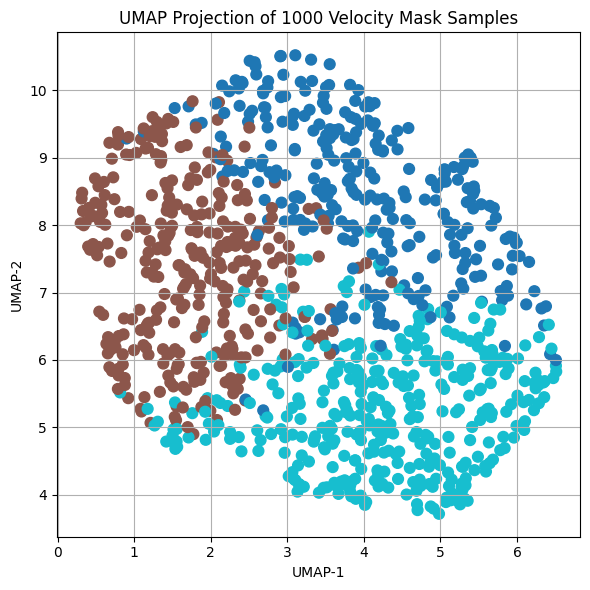

In [46]:
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_pca)

plt.figure(figsize=(6, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab10', s=60)
# for i, sid in enumerate(sample_ids):
#     plt.text(X_umap[i, 0], X_umap[i, 1], sid.split(".")[0], fontsize=8)
plt.title("UMAP Projection of 1000 Velocity Mask Samples")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
from sklearn.metrics import silhouette_score
print("Silhouette score:", silhouette_score(X_pca, labels))


Silhouette score: 0.11443665494607146


In [ ]:
df = pd.DataFrame({
    "sample_id": sample_ids,
    "cluster": labels
})
df.to_csv("clustering_results_10samples.csv", index=False)
print("Saved clustering results to clustering_results_10samples.csv")